<a href="https://colab.research.google.com/github/Fournierp/alfred/blob/streamlit/models/RL%20Gym%20Stock%20Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Stock Market Data

In this kernel, we will design a custom Gym environment to train a model we will use in our web app. We will develop a RL agent and harness its capability to learn to act anticipating the results of its actions. This model will take as input Closing Stock Prices of previous days and predict the optimal decision (to hold, sell or buy).

In [1]:
!pip install yfinance
%tensorflow_version 1.x
!pip install stable-baselines[mpi]==2.10.0

TensorFlow 1.x selected.


In [2]:
import gym
from gym import spaces
import numpy as np
import random
import yfinance as yf

INITIAL_ACCOUNT_BALANCE = 1000

MAX_ACCOUNT_BALANCE = 2147483647
MAX_NUM_SHARES = 2147483647
MAX_SHARE_PRICE = 1000

class CustomEnv(gym.Env):
    # Inspired from: https://towardsdatascience.com/creating-a-custom-openai-gym-environment-for-stock-trading-be532be3910e
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df):
        super(CustomEnv, self).__init__()    
        
        # Data
        self.df = df.loc[:, ['Volume', 'Open', 'Close']].values

        # Action and observation space
        self.action_space = spaces.Box(low=np.array([0, 0]),
                                       high=np.array([3, 1]))
        self.observation_space = spaces.Box(low=0, high=1, shape=(3, 5))

    def step(self, action):
        # Execute one time step within the environment
        self._take_action(action)
        
        self.date += 1
        
        if self.date > len(self.df[:, 0]) - 7 or self.balance <= 0:
            done = True
        else:
            done = False

        obs = self._next_state()

        reward = self.net_worth / MAX_ACCOUNT_BALANCE

        return obs, reward, done, {}    

    def reset(self):
        # Reset the state of the environment to an initial state
        self.balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.shares_value = 0
        self.shares_held = 0
        self.shares_sold = 0

        # Set the current step to a random point within the data frame
        self.date = random.randint(0, len(self.df[:, 0]) - 6)  
        
        return self._next_state()

    def _next_state(self):
        # Get the data points for the last 5 days and normalize it
        frame = np.array([
          self.df[self.date:self.date + 5, 2] / MAX_SHARE_PRICE,
          self.df[self.date:self.date + 5, 0] / MAX_NUM_SHARES,
        ])

        state = np.append(frame,
                          [[
                            self.balance / MAX_ACCOUNT_BALANCE,
                            self.net_worth / MAX_ACCOUNT_BALANCE,
                            self.shares_value / MAX_ACCOUNT_BALANCE,
                            self.shares_held / MAX_NUM_SHARES,
                            self.shares_sold / MAX_NUM_SHARES
                            ]],
                          axis=0)

        return state

    def _take_action(self, action):
        # Set the current price to a random price within the time step
        current_price = random.uniform(
            self.df[self.date, 1],
            self.df[self.date, 2])

        action_type = action[0]
        amount = action[1]

        if action_type < 1:
            # Buy amount % of balance in shares
            total_possible = int(self.balance / current_price)
            shares_bought = int(total_possible * amount)
            additional_cost = shares_bought * current_price
            
            self.balance -= additional_cost
            self.shares_held += shares_bought

        elif action_type < 2:
            # Sell amount % of shares held
            shares_sold = int(self.shares_held * amount)

            self.balance += shares_sold * current_price
            self.shares_held -= shares_sold
            self.shares_sold += shares_sold

        self.shares_value = self.shares_held * current_price
        self.net_worth = self.balance + self.shares_value

    def render(self, mode='human', close=False):
        # Render the environment to the screen
        print('\t'.join(map(str, ["{}".format(self.date),
                                  "{0:02f}".format(self.balance),
                                  "{0:02f}".format(self.net_worth),
                                  "{0:02f}".format(self.shares_value),
                                  "{}".format(self.shares_held),
                                  "{}".format(self.shares_sold)])))

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

[*********************100%***********************]  1 of 1 completed




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.



/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Num timesteps: 7000
Best mean reward: -inf - Last mean reward per episode: 0.07
Saving new best model to tmp/best_model
Num timesteps: 8000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 9000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 10000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 11000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 12000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 13000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 14000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 15000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 16000
Best mean reward: 0.07 - Last mean reward per episode: 0.17
Saving new best model to tmp/best_model
Num timesteps

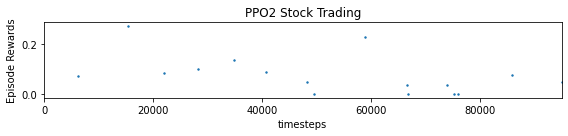

In [4]:
import os

import matplotlib.pyplot as plt

from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from stable_baselines import results_plotter
from stable_baselines.bench import Monitor
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines.common.callbacks import BaseCallback

class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Source: https://stable-baselines.readthedocs.io/en/master/guide/examples.html
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print("Num timesteps: {}".format(self.num_timesteps))
                print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print("Saving new best model to {}".format(self.save_path))
                  self.model.save(self.save_path)

        return True

df = yf.download('AAPL')

# Create log dir
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)

env = CustomEnv(df)
env = Monitor(env, log_dir)
model = PPO2(MlpPolicy, env, verbose=0)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
time_steps = 1e5
model.learn(total_timesteps=int(time_steps), callback=callback)

results_plotter.plot_results([log_dir], time_steps, results_plotter.X_TIMESTEPS, "PPO2 Stock Trading")
plt.show()

In [5]:
obs = env.reset()

print('\t'.join(map(str, ["Step",
                          "Balance  ",
                          "Net worth",
                          "Shares value",
                          "Shares held",
                          "Shares sold"])))

done = False
while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
5118	0.241355	10109.678254	10109.436899	28486	1526602
5119	0.241355	9777.165487	9776.924132	28486	1526602
5120	0.241355	10168.470501	10168.229147	28486	1526602
5121	0.241355	10364.515498	10364.274143	28486	1526602
5122	0.241355	10160.956078	10160.714723	28486	1526602
5123	0.241355	10653.246716	10653.005361	28486	1526602
5124	0.241355	11665.309086	11665.067731	28486	1526602
5125	0.241355	11554.006798	11553.765444	28486	1526602
5126	0.241355	11566.821834	11566.580479	28486	1526602
5127	4848.341259	11271.193275	6422.852016	16233	1538855
5128	4848.341259	11173.284436	6324.943177	16233	1538855
5129	4848.341259	11365.062488	6516.721229	16233	1538855
5130	4848.341259	11243.529109	6395.187850	16233	1538855
5131	4848.341259	10744.558156	5896.216897	16233	1538855
5132	4848.341259	10529.459707	5681.118447	16233	1538855
5133	3872.414709	10876.581629	7004.166920	18861	1538855
5134	3872.414709	10827.012753	6954.598045	1886